In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import sys
sys.path.append("../scripts")
import data
import models
import utils

%load_ext autoreload
%autoreload 2

In [2]:
def get_subgroup_feature(dataset, X_train, X_val, X_test):
    if dataset == "german":
        A_train = X_train.Gender.astype(str) + "_" + (X_train.Age > 50).astype(str)
        A_val = X_val.Gender.astype(str) + "_" + (X_val.Age > 50).astype(str)
        A_test = X_test.Gender.astype(str) + "_" + (X_test.Age > 50).astype(str)
    elif dataset == "adult":
        A_train = X_train.sex.astype(str) + "_" + (X_train.age > 50).astype(str)
        A_val = X_val.sex.astype(str) + "_" + (X_val.age > 50).astype(str)
        A_test = X_test.sex.astype(str) + "_" + (X_test.age > 50).astype(str)

    sensitive_map = dict([(attr, i) for i, attr in enumerate(A_train.unique())])
    A_train = A_train.map(sensitive_map)
    A_val = A_val.map(sensitive_map)
    A_test = A_test.map(sensitive_map)
    return A_train, A_val, A_test



In [3]:
cat_features = data.CAT_FEATURES["german"]
num_features = data.NUM_FEATURES["german"]
col_trans = ColumnTransformer(
    [
        ("numeric", StandardScaler(), num_features),
        (
            "categorical",
            OneHotEncoder(
                drop="if_binary", sparse_output=False, handle_unknown="ignore"
            ),
            cat_features,
        ),
    ],
    verbose_feature_names_out=False,
)
col_trans.set_output(transform="pandas")

X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold("german", 0, 0)
A_train, A_val, A_test = get_subgroup_feature("german", X_train, X_val, X_test)

preprocess = Pipeline([("preprocess", col_trans)])
preprocess.fit(X_train)
X_train = preprocess.transform(X_train)
X_val = preprocess.transform(X_val)
X_test = preprocess.transform(X_test)

In [4]:
counts = A_train.value_counts().to_dict()

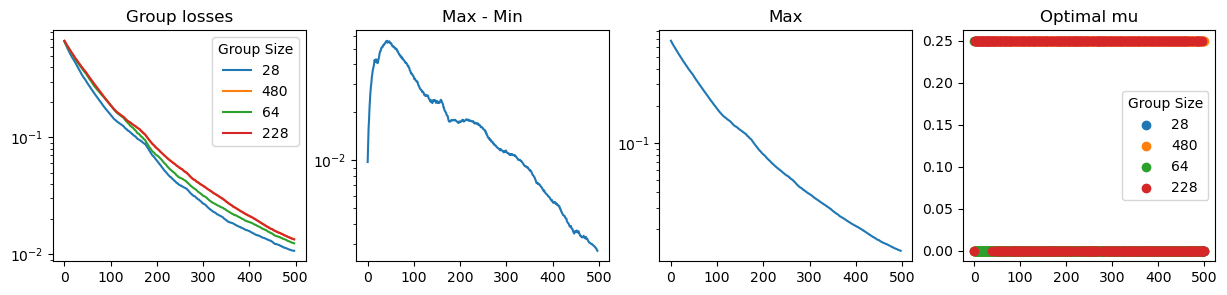

In [20]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'eta': 0.02, 'max_depth': 8, 'l2_weight': 0, 'fair_weight': 0.25}
model = models.XtremeFair_1(**params)
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()

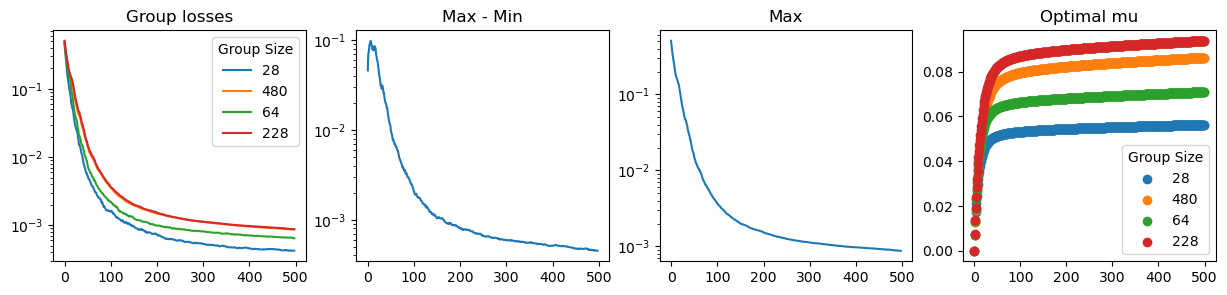

In [21]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'eta': 0.2, 'max_depth': 8, 'l2_weight': 0, 'fair_weight': 0.25, 'multiplier_learning_rate': 0.05}
model = models.XtremeFair_1(dual_learning="gradient", **params)
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()

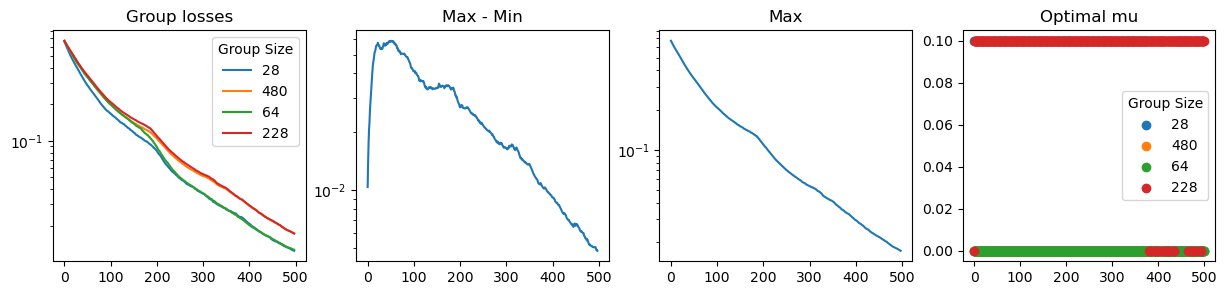

In [22]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'eta': 0.02, 'max_depth': 8, 'l2_weight': 0, 'fair_weight': 0.1}
model = models.XtremeFair_1(**params)
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()

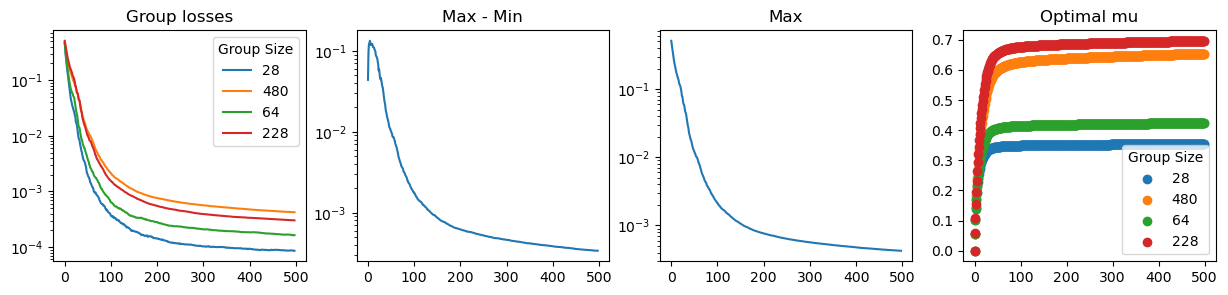

In [23]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'eta': 0.2, 'max_depth': 8, 'l2_weight': 0, 'fair_weight': 0.1, 'multiplier_learning_rate': 1}
model = models.XtremeFair_1(dual_learning="gradient", **params)
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()

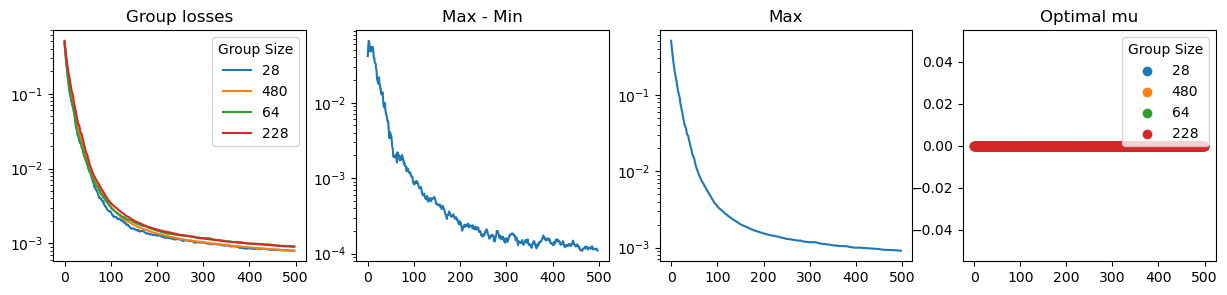

In [24]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'eta': 0.2, 'max_depth': 8, 'l2_weight': 0, 'fair_weight': 0, 'multiplier_learning_rate': 0.05}
model = models.XtremeFair_1(dual_learning="gradient", **params)
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


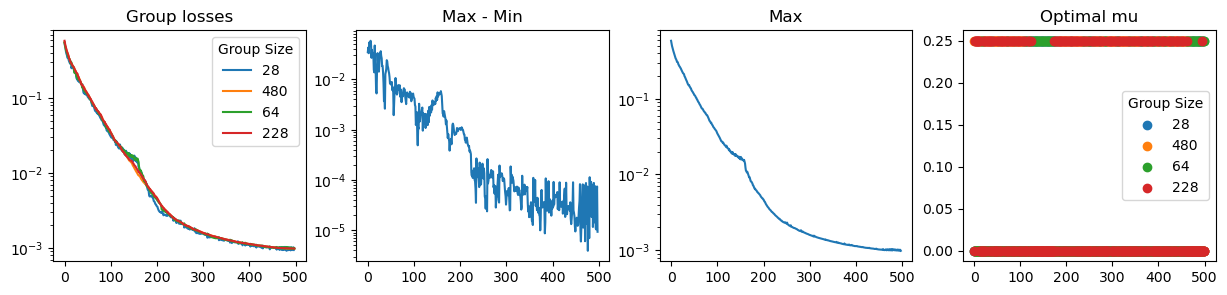

In [25]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 8, 'reg_lambda': 0, 'fair_weight': 0.25, 'multiplier_learning_rate': 0.05}
model = models.XtremeFair_LGBM(**params)
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


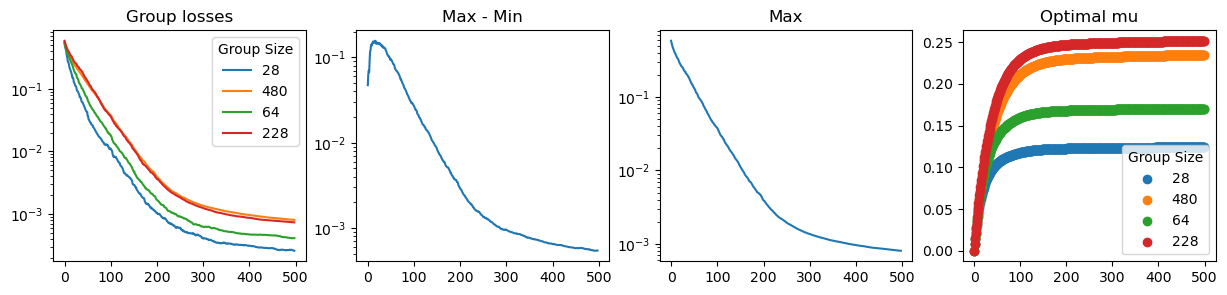

In [26]:
params = {'min_child_weight': 0.1, 'n_estimators': 500, 'learning_rate': 0.2, 'max_depth': 8, 'reg_lambda': 0, 'fair_weight': 0.25, 'multiplier_learning_rate': 0.05}
model = models.XtremeFair_LGBM(**params, dual_learning="gradient")
model.fit(X_train, Y_train, A_train)
fig = plt.figure(figsize = (15, 3))
plt.subplot(1, 4, 1)
for i in range(4):
    plt.plot(model.group_losses[:, i], label = counts[i])
plt.legend(title = "Group Size")
#plt.ylim(0, 0.1)
plt.yscale("log")
plt.title("Group losses")

plt.subplot(1, 4, 2)
max_loss = model.group_losses.max(axis = 1)
min_loss = model.group_losses.min(axis = 1)
plt.plot(max_loss - min_loss)
plt.yscale("log")
plt.title("Max - Min")

plt.subplot(1, 4, 3)
plt.plot(max_loss)
plt.yscale("log")
plt.title("Max")

plt.subplot(1, 4, 4)
for i in range(4):
    plt.scatter(
        np.arange(model.mu_opt_list.shape[0]),
        model.mu_opt_list[:, i], label = counts[i]
        )
plt.legend(title = "Group Size")
plt.title("Optimal mu")
plt.show()